In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time

In [2]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)

spectractordir=workbookDir+"/../../Spectractor"
print('spectractordir: ' + spectractordir)
toolsdir=workbookDir+"/../common_tools"
print("toolsdir:",toolsdir)


import sys
sys.path.append(workbookDir)
sys.path.append(spectractordir)
sys.path.append(os.path.dirname(workbookDir))
sys.path.append(toolsdir)



from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook
from spectractor.extractor.dispersers import *
from spectractor.extractor.spectrum import *
from spectractor.tools import ensure_dir

from libatmscattering import *


plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(20,20)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points



workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None
spectractordir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../../Spectractor
toolsdir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../common_tools


In [3]:
######### CONFIGURATION

## wavelength
WLMIN = 380.0
WLMAX = 1000.0
#NBWLBIN = 62
NBWLBIN = 124
WLBINWIDTH = (WLMAX - WLMIN) / float(NBWLBIN)

WLMINBIN = np.arange(WLMIN, WLMAX, WLBINWIDTH)
WLMAXBIN = np.arange(WLMIN + WLBINWIDTH, WLMAX + WLBINWIDTH, WLBINWIDTH)
WLMEANBIN=(WLMINBIN + WLMAXBIN)/2.



print('WLMINBIN..................................=', WLMINBIN.shape, WLMINBIN)
print('WLMAXBIN..................................=', WLMAXBIN.shape, WLMAXBIN)
print('NBWLBIN...................................=', NBWLBIN)
print('WLBINWIDTH................................=', WLBINWIDTH)

## colors

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBWLBIN)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBWLBIN), alpha=1)

## output directory for tables
#ouputtabledir="outputtabledir"

## create output directory
#ensure_dir(ouputtabledir)

WLMINBIN..................................= (124,) [380. 385. 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445.
 450. 455. 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515.
 520. 525. 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585.
 590. 595. 600. 605. 610. 615. 620. 625. 630. 635. 640. 645. 650. 655.
 660. 665. 670. 675. 680. 685. 690. 695. 700. 705. 710. 715. 720. 725.
 730. 735. 740. 745. 750. 755. 760. 765. 770. 775. 780. 785. 790. 795.
 800. 805. 810. 815. 820. 825. 830. 835. 840. 845. 850. 855. 860. 865.
 870. 875. 880. 885. 890. 895. 900. 905. 910. 915. 920. 925. 930. 935.
 940. 945. 950. 955. 960. 965. 970. 975. 980. 985. 990. 995.]
WLMAXBIN..................................= (124,) [ 385.  390.  395.  400.  405.  410.  415.  420.  425.  430.  435.  440.
  445.  450.  455.  460.  465.  470.  475.  480.  485.  490.  495.  500.
  505.  510.  515.  520.  525.  530.  535.  540.  545.  550.  555.  560.
  565.  570.  575.  580.  585.  590.  595.  600. 

In [4]:
#---------------------------------------------------------------------
def GetWLBin(wl):
    """

    :param wl: wavelength scalar
    :return: index
    """

    set_ibin = np.where(np.logical_and(WLMINBIN <= wl, WLMAXBIN > wl))[0]

    if len(set_ibin)==1:
        return set_ibin[0]
    else:
        return -1
#---------------------------------------------------------------------
def GETWLLabels():

    all_labels=[]
    for idx in np.arange(NBWLBIN):
        label="$\lambda$ : {:3.0f}-{:3.0f} nm".format(WLMINBIN[idx], WLMAXBIN[idx])
        all_labels.append(label)
    all_labels=np.array(all_labels)
    return all_labels
#------------------------------------------------------------------------

WLLABELS=GETWLLabels()

In [5]:
# where are the spectra
#----------------------
thedate = "20190215"
#input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod3/" + thedate
input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/" + thedate
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [6]:
#-------------------------------------------------------------------------------------
def GetAllFiles(dir):
    """
    GetAllFiles(dir): provides the list of relevant files inside the directory dir


    :param dir: input directory pathname
    :return: list of files
    """



    # get all files
    onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
    onlyfiles = np.array(onlyfiles)

    # sort files
    sortedindexes = np.argsort(onlyfiles)
    onlyfiles = onlyfiles[sortedindexes]

    # get only _spectrum.fits file
    onlyfilesspectrum = []
    for file_name in onlyfiles:
        if re.search("^T.*_spectrum.fits$", file_name):
            # check if other files exits

            filetype = file_name.split('.')[-1]

            output_filename = os.path.basename(file_name)
            output_filename = os.path.join(dir, output_filename)
            output_filename_spectrogram = output_filename.replace('spectrum', 'spectrogram')
            output_filename_psf = output_filename.replace('spectrum.fits', 'table.csv')

            # go to next simulation if output files already exists
            if os.path.isfile(output_filename) and os.path.isfile(output_filename_spectrogram) and os.path.isfile(
                    output_filename_psf):
                filesize = os.stat(output_filename).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename, filesize))

                filesize = os.stat(output_filename_spectrogram).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename_spectrogram,
                                                                                       filesize))

                filesize = os.stat(output_filename_psf).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename_psf, filesize))

                onlyfilesspectrum.append(re.findall("(^T.*_spectrum.fits$)", file_name)[0])

    # sort again all the files
    onlyfilesspectrum = np.array(onlyfilesspectrum)
    sortedindexes = np.argsort(onlyfilesspectrum)
    onlyfilesspectrum = onlyfilesspectrum[sortedindexes]

    # get basnemae of files for later use (to check if _table.csv and _spectrogram.fits exists
    onlyfilesbasename = []
    for f in onlyfilesspectrum:
        onlyfilesbasename.append(re.findall("(^T.*)_spectrum.fits$", f)[0])


    return onlyfilesspectrum,onlyfilesbasename

In [7]:
def ReadAllFiles(dir, filelist):
    """

    ReadAllFiles(dir, filelist): Read all files

    :param dir: input directory
    :param filelist: list fo files
    :return: various containers
    """


    # init all container
    all_indexes=[]   # continuous index
    all_eventnum=[]  # event number on filename

    all_airmass=[]   #airmass

    all_lambdas = [] # wavelength

    #fluxes
    all_flux=[]
    all_errflux=[]


    # magnitudes
    all_mag=[]
    all_errmag=[]

    # absorption (Magnitude corrected from Rayleigh
    all_abs=[]
    all_errabs=[]


    all_dt       = []   # time since beginning in hours
    all_datetime = []   # datetime

    # preselection flag
    all_flag = []


    #bad indexes and filename
    all_badidx=[]
    all_badfn=[]


    all_BGimg=[]
    all_Rawimg=[]

    NBSPEC = len(filelist)


    #----------------------------------
    # Extract spectra information from files
    # compute magnitudes
    #-----------------------------

    count=-1  #counter of good files before filtering

    # loop on all files
    for idx in np.arange(0, NBSPEC):
        if idx==322:
            print("SKIP bad file",filelist[idx] )
            continue

        count+=1

        theeventnum = int(filelist[idx].split(".")[1].split("_")[0])


        print(" read {}) : event {} , file {}".format(idx,theeventnum,filelist[idx]))


        fullfilename = os.path.join(dir, filelist[idx])
        fullfilename_spectrogram = fullfilename.replace('spectrum', 'spectrogram')
        rawfilename = filelist[idx].replace('_spectrum.fits', '.fit')
        fillrawfilename=os.path.join(rawinput_directory,rawfilename)
        

        #try:
        if 1:
            # read fits file
            hdu = fits.open(fullfilename)
            hdu2=fits.open(fullfilename_spectrogram)
            hdu3=fits.open(fillrawfilename)

            

            # decode header
            header=hdu[0].header

            am=header["AIRMASS"]
            date=header["DATE-OBS"]

            if idx==0:
                T0=t = Time(date, format='isot', scale='utc')
            T=Time(date, format='isot', scale='utc')
            thedatetime=T.to_datetime()

            DT=(T-T0).sec/(3600.0)  # convert in hours


            # decode data
            data=hdu[0].data

            # extract wavelength, spectrum and errors
            wavelength=data[0,:]
            spec = data[1,:]
            err=data[2,: ]

            if(len(wavelength)==0 or len(spec)==0 or len(err)==0):
                print(">>>>>>>>>>>>>>  Empty file ",idx,")::",onlyfilesspectrum[idx] )
                print(">>>>>>>>>>>>>>>>>>>>>>>>>>>",len(wavelength)," , ",len(spec0), " , ",len(err))



            # sort the wavelengths
            wl_sorted_idx=np.argsort(wavelength)

            wl=wavelength[wl_sorted_idx]
            fl=spec[wl_sorted_idx]
            errfl=err[wl_sorted_idx]
            wlbins = [GetWLBin(w) for w in wl]
            wlbins = np.array(wlbins)


            # defines good measurmements as flux >0 and wavelength in selected bons
            goodpoints=np.where(np.logical_and(fl != 0, wlbins != -1))

            if(len(goodpoints)==0):
                print(">>>>>>>>>>>>>>  No Good points  ", idx, ")::", onlyfilesspectrum[idx])
                print(">>>>>>>>>>>>>>  No Good points  ", "wl = ",wl)
                print(">>>>>>>>>>>>>>  No Good points  ", "fl = ", fl)
                print(">>>>>>>>>>>>>>  No Good points  ", "errfl = ", errfl)



            # keep good points (wl,flux)
            wl=wl[goodpoints]
            fl=fl[goodpoints]
            errfl=errfl[goodpoints]


            # convert flux into magnitudes for each wavelength
            mag = -2.5 * np.log10(fl)
            errmag = errfl/fl

            #compute effective slant Rayleigh optical depth (not the vertical optical depth)
            od_adiab = RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1./am)  # Rayleigh optical depth

            # absorption magnitude corrected from Rayleigh attenuation
            abs=mag-2.5/np.log(10.)*od_adiab
            errabs=errmag





            # save for each observation  { event-id, airmass, set of points (wl,flux,errflux, mag,abs,errabs) }
            if(len(mag>0)):
                #all_indexes.append(idx)
                all_indexes.append(count)
                all_eventnum.append(theeventnum)
                all_airmass.append(am)
                all_lambdas.append(wl)
                all_flux.append(fl)
                all_errflux.append(errfl)
                all_mag.append(mag)
                all_errmag.append(errmag)
                all_abs.append(abs)
                all_errabs.append(errabs)
                all_dt.append(DT)
                all_datetime.append(thedatetime)
                all_BGimg.append(hdu2[2].data)
                all_Rawimg.append(hdu3[0].data)

                absmin = abs.min()
                absmax = abs.max()


                # Set a quality flag
                if absmin < 25 or absmax > 32:
                    print("file index idx = ", count, "==>  filename = ", onlyfilesspectrum[idx], " absmin= ", absmin,
                          " absmax = ", absmax)
                    all_flag.append(False)
                    all_badidx.append(count)
                    all_badfn.append(onlyfilesspectrum[idx])
                else:
                    all_flag.append(True)



        #except:
        if 0:
            print("Unexpected error:", sys.exc_info()[0])
            pass

    # transform container in numpy arrays
    all_indexes=np.array(all_indexes)
    all_eventnum = np.array(all_eventnum)

    all_airmass = np.array(all_airmass)

    all_lambdas = np.array(all_lambdas)

    all_flux = np.array(all_flux)
    all_errflux = np.array(all_errflux)


    all_mag=np.array(all_mag)
    all_errmag=np.array(all_errmag)

    all_abs = np.array(all_abs)
    all_errabs = np.array(all_errabs)

    all_dt = np.array(all_dt)
    all_datetime=np.array(all_datetime)

    all_flag = np.array(all_flag)

    all_badidx=np.array(all_badidx)
    all_badfn=np.array(all_badfn)


    return all_indexes,all_eventnum,all_airmass,all_lambdas,all_flux,all_errflux,all_mag,all_errmag,all_abs,all_errabs,all_dt,all_datetime,all_flag,all_badidx,all_badfn, all_BGimg, all_Rawimg


In [9]:
#############################################
# 1) Get list of files
##########################################
onlyfilesspectrum,onlyfilesbasename=GetAllFiles(input_directory)



>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits already exists with size 54720 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrogram.fits already exists with size 40700160 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_table.csv already exists with size 640113 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrum.fits already exists with size 54720 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrogram.fits already exists with size 408297

In [10]:
#############################################
# 2) Read fits file
##########################################


NBSPEC = len(onlyfilesspectrum)

print('NBSPEC....................................= ', NBSPEC)


all_indexes, all_eventnum, all_airmass, all_lambdas, all_flux, all_errflux, all_mag, all_errmag, all_abs, all_errabs, all_dt, all_datetime, all_flag, all_badidx, all_badfn, all_BGimg, all_Rawimg=ReadAllFiles(input_directory, onlyfilesspectrum)


NBSPEC....................................=  348
 read 0) : event 1 , file T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits
 read 1) : event 2 , file T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrum.fits
 read 2) : event 3 , file T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red_spectrum.fits
 read 3) : event 4 , file T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red_spectrum.fits
 read 4) : event 5 , file T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red_spectrum.fits
 read 5) : event 6 , file T1M_20190215_225847_115_HD116405_Filtre_None_bin1x1.6_red_spectrum.fits
 read 6) : event 7 , file T1M_20190215_225922_399_HD116405_Filtre_None_bin1x1.7_red_spectrum.fits
 read 7) : event 8 , file T1M_20190215_225957_677_HD116405_Filtre_None_bin1x1.8_red_spectrum.fits
 read 8) : event 9 , file T1M_20190215_230032_956_HD116405_Filtre_None_bin1x1.9_red_spectrum.fits
 read 9) : event 10 , file T1M_20190215_230108_233_HD116405_Filtre_No

 read 91) : event 92 , file T1M_20190215_234921_136_HD116405_Filtre_None_bin1x1.92_red_spectrum.fits
 read 92) : event 93 , file T1M_20190215_234956_414_HD116405_Filtre_None_bin1x1.93_red_spectrum.fits
 read 93) : event 94 , file T1M_20190215_235031_692_HD116405_Filtre_None_bin1x1.94_red_spectrum.fits
 read 94) : event 95 , file T1M_20190215_235106_968_HD116405_Filtre_None_bin1x1.95_red_spectrum.fits
 read 95) : event 96 , file T1M_20190215_235142_245_HD116405_Filtre_None_bin1x1.96_red_spectrum.fits
 read 96) : event 97 , file T1M_20190215_235217_522_HD116405_Filtre_None_bin1x1.97_red_spectrum.fits
 read 97) : event 98 , file T1M_20190215_235252_800_HD116405_Filtre_None_bin1x1.98_red_spectrum.fits
 read 98) : event 99 , file T1M_20190215_235328_078_HD116405_Filtre_None_bin1x1.99_red_spectrum.fits
 read 99) : event 100 , file T1M_20190215_235403_356_HD116405_Filtre_None_bin1x1.100_red_spectrum.fits
 read 100) : event 101 , file T1M_20190215_235438_632_HD116405_Filtre_None_bin1x1.101_red

 read 178) : event 76 , file T1M_20190216_005909_993_HD116405_Filtre_None_bin1x1.76_red_spectrum.fits
 read 179) : event 77 , file T1M_20190216_005945_273_HD116405_Filtre_None_bin1x1.77_red_spectrum.fits
 read 180) : event 91 , file T1M_20190216_011616_622_HD116405_Filtre_None_bin1x1.91_red_spectrum.fits
 read 181) : event 92 , file T1M_20190216_011651_941_HD116405_Filtre_None_bin1x1.92_red_spectrum.fits
 read 182) : event 93 , file T1M_20190216_011727_230_HD116405_Filtre_None_bin1x1.93_red_spectrum.fits
 read 183) : event 94 , file T1M_20190216_011802_525_HD116405_Filtre_None_bin1x1.94_red_spectrum.fits
 read 184) : event 95 , file T1M_20190216_011837_817_HD116405_Filtre_None_bin1x1.95_red_spectrum.fits
 read 185) : event 96 , file T1M_20190216_011913_114_HD116405_Filtre_None_bin1x1.96_red_spectrum.fits
 read 186) : event 97 , file T1M_20190216_011948_412_HD116405_Filtre_None_bin1x1.97_red_spectrum.fits
 read 187) : event 98 , file T1M_20190216_012023_703_HD116405_Filtre_None_bin1x1.9

 read 261) : event 275 , file T1M_20190216_031553_551_HD116405_Filtre_None_bin1x1.275_red_spectrum.fits
 read 262) : event 292 , file T1M_20190216_032830_153_HD116405_Filtre_None_bin1x1.292_red_spectrum.fits
 read 263) : event 297 , file T1M_20190216_033126_585_HD116405_Filtre_None_bin1x1.297_red_spectrum.fits
file index idx =  263 ==>  filename =  T1M_20190216_033126_585_HD116405_Filtre_None_bin1x1.297_red_spectrum.fits  absmin=  26.040655365937745  absmax =  32.5090419754095
 read 264) : event 298 , file T1M_20190216_033201_871_HD116405_Filtre_None_bin1x1.298_red_spectrum.fits
file index idx =  264 ==>  filename =  T1M_20190216_033201_871_HD116405_Filtre_None_bin1x1.298_red_spectrum.fits  absmin=  29.980669181146947  absmax =  32.052708790466944
 read 265) : event 299 , file T1M_20190216_033237_157_HD116405_Filtre_None_bin1x1.299_red_spectrum.fits
 read 266) : event 300 , file T1M_20190216_033312_445_HD116405_Filtre_None_bin1x1.300_red_spectrum.fits
file index idx =  266 ==>  filenam

 read 306) : event 382 , file T1M_20190216_042908_060_HD116405_Filtre_None_bin1x1.382_red_spectrum.fits
 read 307) : event 383 , file T1M_20190216_042943_342_HD116405_Filtre_None_bin1x1.383_red_spectrum.fits
 read 308) : event 384 , file T1M_20190216_043018_622_HD116405_Filtre_None_bin1x1.384_red_spectrum.fits
 read 309) : event 385 , file T1M_20190216_043053_905_HD116405_Filtre_None_bin1x1.385_red_spectrum.fits
 read 310) : event 386 , file T1M_20190216_043129_184_HD116405_Filtre_None_bin1x1.386_red_spectrum.fits
 read 311) : event 387 , file T1M_20190216_043204_464_HD116405_Filtre_None_bin1x1.387_red_spectrum.fits
 read 312) : event 388 , file T1M_20190216_043239_743_HD116405_Filtre_None_bin1x1.388_red_spectrum.fits
 read 313) : event 389 , file T1M_20190216_043315_022_HD116405_Filtre_None_bin1x1.389_red_spectrum.fits
 read 314) : event 390 , file T1M_20190216_043350_300_HD116405_Filtre_None_bin1x1.390_red_spectrum.fits
 read 315) : event 391 , file T1M_20190216_043425_578_HD116405_F

In [11]:
NBSPEC

348

In [19]:
index=0
image=all_Rawimg[index]
vmin=image.min()
vmax=image.max()/50.

In [24]:
data=image

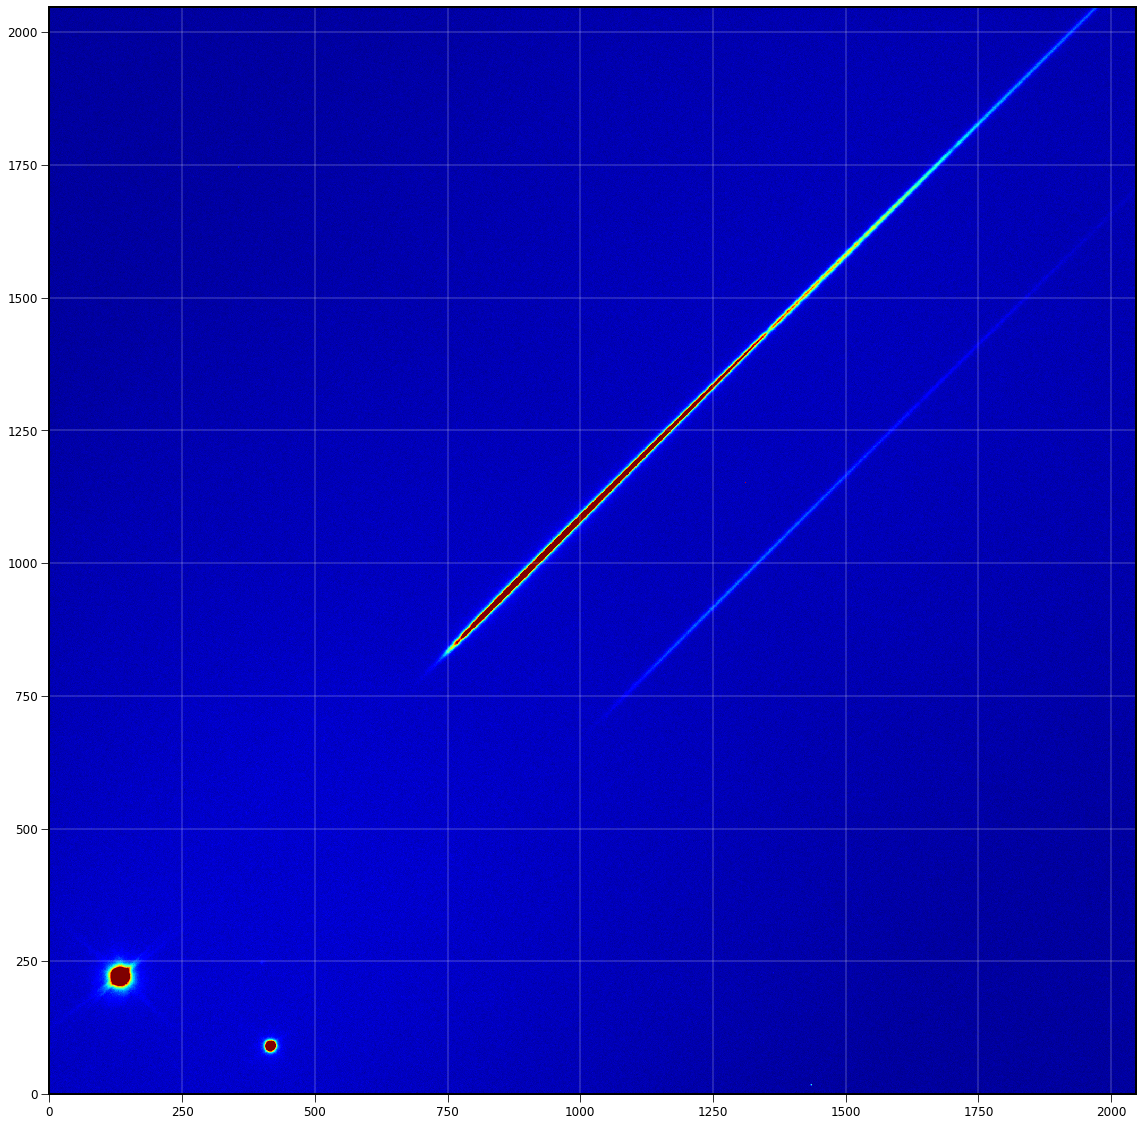

In [64]:
plt.imshow(data,origin="lower",vmin=vmin,vmax=vmax,cmap="jet")
plt.grid(color="w")

In [23]:
from astropy.stats import sigma_clipped_stats


In [25]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
print((mean, median, std))    

(62.683913040066145, 62.160806867873916, 18.221840820359397)


In [47]:
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import DAOStarFinder

In [48]:
daofind = DAOStarFinder(fwhm=10.0, threshold=100.*std)    
sources = daofind(data - median) 

In [49]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)    

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 416.82349 89.841687 0.55505862 ...   0 43021.343 59.484191 -4.4360039
  2 131.36828 220.22083 0.39960252 ...   0 64617.914 54.508733 -4.3411652
  3 135.39845 222.28779 0.32487395 ...   0 64948.867 61.701166 -4.4757334


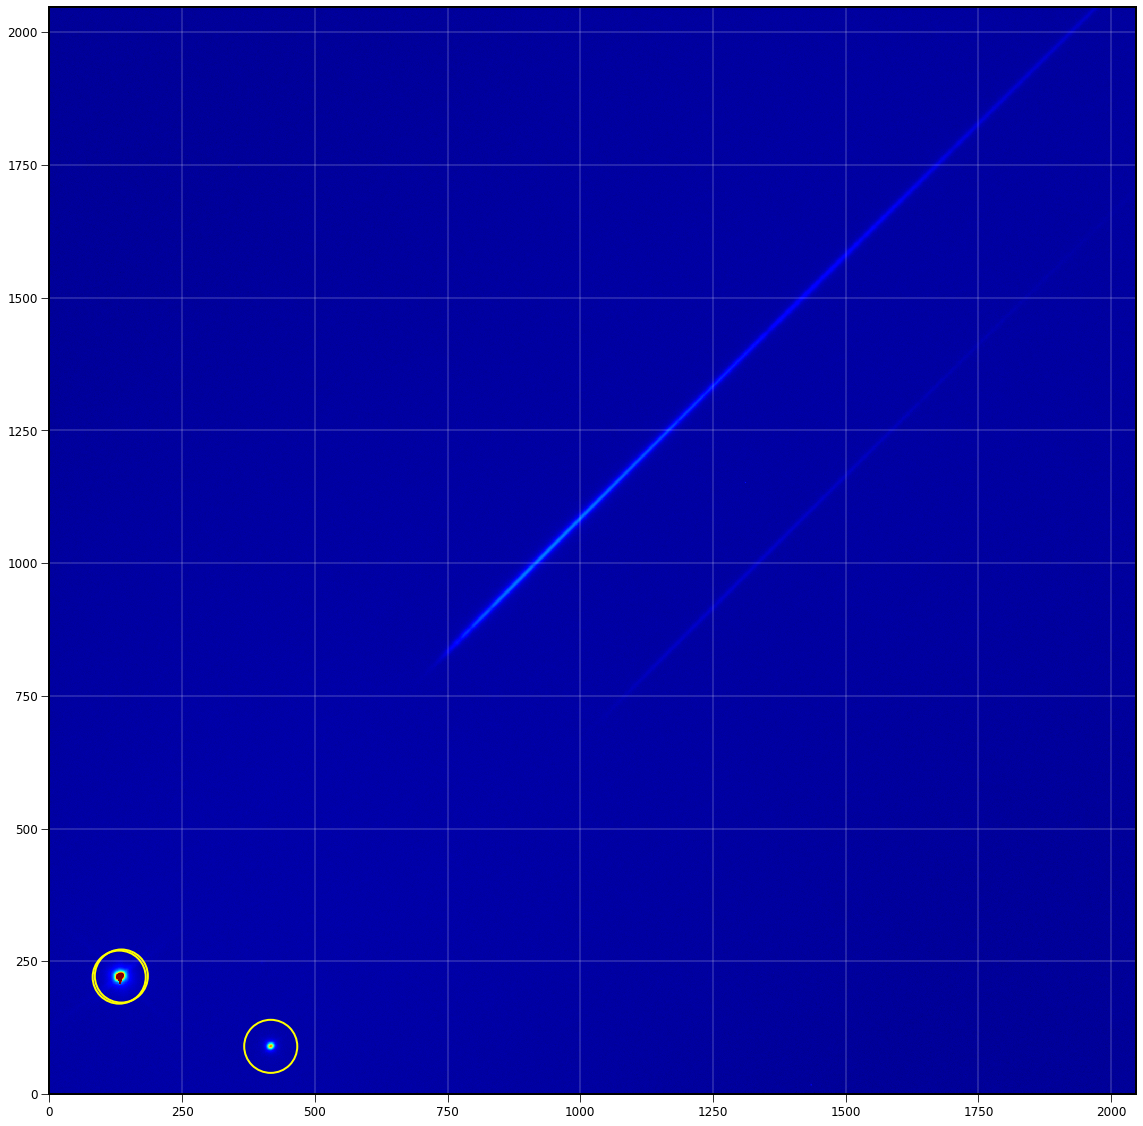

In [66]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data,cmap='Greys', origin='lower', norm=norm)
plt.imshow(data,cmap='jet', origin='lower', norm=norm)
apertures.plot(color='yellow', lw=2, alpha=1.0)
plt.grid()
plt.grid(color="w")

In [63]:
#from photutils import find_peaks
#mean, median, std = sigma_clipped_stats(data, sigma=10.0)
#threshold = median + (100. * std)
#tbl = find_peaks(data, threshold, box_size=11)
#tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#print(tbl)    # print only the first 10 peak

x_peak y_peak peak_value
------ ------ ----------
   417     90  43083.504
   131    213  65439.947
   131    220  65420.877
   132    226  65383.873
   689    504  3595.9825
   822    905  3106.3266
   849    932  3623.8383
   865    948  3892.9939
   871    955  3937.5257
   882    965  4135.5851
   ...    ...        ...
  1067   1150  3300.2365
  1084   1167  3181.1224
  1091   1174  3175.1331
  1102   1185  3068.8465
  1113   1196  2993.5109
  1138   1221  2815.8724
  1144   1227   2721.559
  1151   1234   2660.486
  1160   1243  2609.6077
  1199   1282  2317.1543
  1206   1289  2254.2732
Length = 31 rows
